In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(14,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,1)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        return self.l3(x)

    def train(self,
              train_loader,
              val_loader=None,
              epochs=100,
              validation_fails=10):

        train_loss_history = []
        val_loss_history = []
        val_fail_history = []
        running_val_fails = 0

        optim = torch.optim.Adam(self.parameters(), 0.001)
        num_samples = len(train_loader.dataset)
        for t in range(epochs):
            print(f"---------- Epoch {t + 1} ----------")
            for batch, (X, Y) in enumerate(train_loader):

                # compute prediction and loss
                pred = self(X)
                loss = F.mse_loss(pred, Y.unsqueeze(1))

                # backpropagation
                optim.zero_grad()
                loss.backward()
                optim.step()
                if batch % 100 == 0:
                    print(f"loss: {loss.item():>4f} [{batch * len(X):>5d}/{num_samples:>5d}]")

            # calculate validation error once per epoch
            train_loss_history.append([t, loss.item()])
            if val_loader is not None:
                loss_history = []
                for (X_val, Y_val) in val_loader:
                    pred_val = self(X_val)
                    loss_val = F.mse_loss(pred_val, Y_val.unsqueeze(1))
                    loss_history.append(loss_val.item())

                loss_val = np.mean(loss_history)
                val_loss_history.append([t, loss_val])
                print(f'training loss: {loss.item():>4f}, validation loss: {loss_val.item():>4f}')

                # early stopping
                if validation_fails is not None and t > 1:
                    if val_loss_history[-2][1] < val_loss_history[-1][1]: # check if validation loss increased
                        running_val_fails += 1
                    else:
                        running_val_fails = 0
                    val_fail_history.append([t, running_val_fails])
                    
                    # abort training if we failed too much
                    if running_val_fails >= validation_fails:
                        print(f'Validation loss did not decrease for {running_val_fails} epochs, training is aborted')
                        break

            else:
                print(f"loss: {loss.item():>4f} [{batch * len(X):>5d}/{num_samples:>5d}]")

        if validation_fails is None:
            return np.array(train_loss_history), np.array(val_loss_history)
        else:
            return np.array(train_loss_history), np.array(val_loss_history), np.array(val_fail_history)

In [3]:
device = "cpu"
if torch.cuda.is_available():
     device = "cuda"
print(f'Device: {device}')

# load csv
d = pd.read_csv("walmart_cleaned.csv")
d = d.drop(["Date", "Unnamed: 0"], axis=1)
d = d.astype("float32")
Y = d["Weekly_Sales"].values
X = d.drop("Weekly_Sales", axis=1).values

# train-val-test split with 70-15-15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# input normalization
mean_x = X_train.mean(axis=0)
std_x = X_train.std(axis=0)
X_train = (X_train - mean_x) / std_x
X_val = (X_val - mean_x) / std_x
X_test = (X_test - mean_x) / std_x

# output normalization
mean_y = Y_train.mean(axis=0)
std_y = Y_train.std(axis=0)
Y_train = (Y_train - mean_y) / std_y
Y_val = (Y_val - mean_y) / std_y
Y_test = (Y_test - mean_y) / std_y

# put train and validation data into tensor dataloader
train_loader = DataLoader(TensorDataset(torch.tensor(X_train).to(device), torch.tensor(Y_train).to(device)),
                          batch_size=1000, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val).to(device), torch.tensor(Y_val).to(device)),
                        batch_size=X_val.shape[0])

Device: cuda


In [4]:
# training
n = Net().to(device)
train_history, val_history, val_fail_history = n.train(train_loader, val_loader, epochs=300)

---------- Epoch 1 ----------
loss: 0.988421 [    0/295099]
loss: 0.921631 [100000/295099]
loss: 0.794595 [200000/295099]
training loss: 0.831601, validation loss: 0.739178
---------- Epoch 2 ----------
loss: 0.719728 [    0/295099]
loss: 0.898175 [100000/295099]
loss: 0.646130 [200000/295099]
training loss: 0.447875, validation loss: 0.692437
---------- Epoch 3 ----------
loss: 0.803544 [    0/295099]
loss: 1.735603 [100000/295099]
loss: 0.669089 [200000/295099]
training loss: 0.526989, validation loss: 0.637249
---------- Epoch 4 ----------
loss: 0.582630 [    0/295099]
loss: 0.527500 [100000/295099]
loss: 0.578717 [200000/295099]
training loss: 0.665459, validation loss: 0.576305
---------- Epoch 5 ----------
loss: 0.549193 [    0/295099]
loss: 0.551747 [100000/295099]
loss: 0.584516 [200000/295099]
training loss: 0.261553, validation loss: 0.509219
---------- Epoch 6 ----------
loss: 0.519978 [    0/295099]
loss: 0.706537 [100000/295099]
loss: 0.451000 [200000/295099]
training loss

loss: 0.280657 [100000/295099]
loss: 0.228941 [200000/295099]
training loss: 0.281733, validation loss: 0.259160
---------- Epoch 49 ----------
loss: 0.201273 [    0/295099]
loss: 0.217140 [100000/295099]
loss: 0.316710 [200000/295099]
training loss: 0.325671, validation loss: 0.274898
---------- Epoch 50 ----------
loss: 0.233897 [    0/295099]
loss: 0.331970 [100000/295099]
loss: 0.255918 [200000/295099]
training loss: 0.128106, validation loss: 0.257118
---------- Epoch 51 ----------
loss: 0.195002 [    0/295099]
loss: 0.211545 [100000/295099]
loss: 0.210536 [200000/295099]
training loss: 0.431509, validation loss: 0.253323
---------- Epoch 52 ----------
loss: 0.171280 [    0/295099]
loss: 0.235961 [100000/295099]
loss: 0.289419 [200000/295099]
training loss: 0.164721, validation loss: 0.257176
---------- Epoch 53 ----------
loss: 0.195592 [    0/295099]
loss: 0.209545 [100000/295099]
loss: 0.322335 [200000/295099]
training loss: 0.228052, validation loss: 0.242126
---------- Epoch 

loss: 0.171249 [200000/295099]
training loss: 0.401459, validation loss: 0.205320
---------- Epoch 96 ----------
loss: 0.187641 [    0/295099]
loss: 0.195142 [100000/295099]
loss: 0.132232 [200000/295099]
training loss: 0.916825, validation loss: 0.185981
---------- Epoch 97 ----------
loss: 0.200440 [    0/295099]
loss: 0.143551 [100000/295099]
loss: 0.148418 [200000/295099]
training loss: 0.104158, validation loss: 0.180298
---------- Epoch 98 ----------
loss: 0.236821 [    0/295099]
loss: 0.151205 [100000/295099]
loss: 0.169179 [200000/295099]
training loss: 0.130958, validation loss: 0.181102
---------- Epoch 99 ----------
loss: 0.148355 [    0/295099]
loss: 0.153676 [100000/295099]
loss: 0.147772 [200000/295099]
training loss: 0.133089, validation loss: 0.184070
---------- Epoch 100 ----------
loss: 0.153166 [    0/295099]
loss: 0.126158 [100000/295099]
loss: 0.260708 [200000/295099]
training loss: 0.155757, validation loss: 0.191407
---------- Epoch 101 ----------
loss: 0.226483 

loss: 0.134402 [200000/295099]
training loss: 0.154880, validation loss: 0.176644
---------- Epoch 143 ----------
loss: 0.105448 [    0/295099]
loss: 0.321907 [100000/295099]
loss: 0.169525 [200000/295099]
training loss: 0.082354, validation loss: 0.162365
---------- Epoch 144 ----------
loss: 0.146393 [    0/295099]
loss: 0.136227 [100000/295099]
loss: 0.208555 [200000/295099]
training loss: 0.106722, validation loss: 0.173485
---------- Epoch 145 ----------
loss: 0.278681 [    0/295099]
loss: 0.161877 [100000/295099]
loss: 0.129257 [200000/295099]
training loss: 0.083659, validation loss: 0.162860
---------- Epoch 146 ----------
loss: 0.102776 [    0/295099]
loss: 0.118005 [100000/295099]
loss: 0.189555 [200000/295099]
training loss: 0.100427, validation loss: 0.174897
---------- Epoch 147 ----------
loss: 0.123608 [    0/295099]
loss: 0.142281 [100000/295099]
loss: 0.135092 [200000/295099]
training loss: 0.085927, validation loss: 0.164888
---------- Epoch 148 ----------
loss: 0.160

loss: 0.142744 [100000/295099]
loss: 0.144703 [200000/295099]
training loss: 1.253671, validation loss: 0.180148
---------- Epoch 190 ----------
loss: 0.127296 [    0/295099]
loss: 0.144860 [100000/295099]
loss: 0.262906 [200000/295099]
training loss: 0.197925, validation loss: 0.161502
---------- Epoch 191 ----------
loss: 0.176296 [    0/295099]
loss: 0.155746 [100000/295099]
loss: 0.121588 [200000/295099]
training loss: 0.217590, validation loss: 0.168480
---------- Epoch 192 ----------
loss: 0.140384 [    0/295099]
loss: 0.219371 [100000/295099]
loss: 0.145328 [200000/295099]
training loss: 0.151743, validation loss: 0.165691
---------- Epoch 193 ----------
loss: 0.141885 [    0/295099]
loss: 0.174313 [100000/295099]
loss: 0.165258 [200000/295099]
training loss: 0.091049, validation loss: 0.165794
---------- Epoch 194 ----------
loss: 0.172602 [    0/295099]
loss: 0.143420 [100000/295099]
loss: 0.156349 [200000/295099]
training loss: 0.155457, validation loss: 0.169432
---------- E

loss: 0.150850 [100000/295099]
loss: 0.090503 [200000/295099]
training loss: 0.194707, validation loss: 0.158652
---------- Epoch 237 ----------
loss: 0.154375 [    0/295099]
loss: 0.132256 [100000/295099]
loss: 0.164701 [200000/295099]
training loss: 0.106588, validation loss: 0.153193
---------- Epoch 238 ----------
loss: 0.124795 [    0/295099]
loss: 0.094710 [100000/295099]
loss: 0.116791 [200000/295099]
training loss: 0.106497, validation loss: 0.151292
---------- Epoch 239 ----------
loss: 0.094841 [    0/295099]
loss: 0.308897 [100000/295099]
loss: 0.104805 [200000/295099]
training loss: 0.090065, validation loss: 0.165203
---------- Epoch 240 ----------
loss: 0.145113 [    0/295099]
loss: 0.109932 [100000/295099]
loss: 0.280273 [200000/295099]
training loss: 0.079593, validation loss: 0.150668
---------- Epoch 241 ----------
loss: 0.158381 [    0/295099]
loss: 0.152760 [100000/295099]
loss: 0.151407 [200000/295099]
training loss: 0.098000, validation loss: 0.155130
---------- E

loss: 0.123803 [100000/295099]
loss: 0.146460 [200000/295099]
training loss: 0.137998, validation loss: 0.147168
---------- Epoch 284 ----------
loss: 0.111850 [    0/295099]
loss: 0.120635 [100000/295099]
loss: 0.219985 [200000/295099]
training loss: 0.123923, validation loss: 0.153749
---------- Epoch 285 ----------
loss: 0.131910 [    0/295099]
loss: 0.116035 [100000/295099]
loss: 0.119558 [200000/295099]
training loss: 0.122821, validation loss: 0.152114
---------- Epoch 286 ----------
loss: 0.107170 [    0/295099]
loss: 0.141281 [100000/295099]
loss: 0.146775 [200000/295099]
training loss: 0.114421, validation loss: 0.151751
---------- Epoch 287 ----------
loss: 0.127655 [    0/295099]
loss: 0.162203 [100000/295099]
loss: 0.131222 [200000/295099]
training loss: 0.088783, validation loss: 0.155618
---------- Epoch 288 ----------
loss: 0.102609 [    0/295099]
loss: 0.157491 [100000/295099]
loss: 0.112359 [200000/295099]
training loss: 0.075667, validation loss: 0.146264
---------- E

In [26]:
# console output
train_loss = train_history[-1, 1]
val_loss = train_history[-1, 1]
test_loss = F.mse_loss(n(torch.tensor(X_test).to(device)), torch.tensor(Y_test).to(device).unsqueeze(1)).item()
print('\nLosses:')
print(f'Train:      {train_loss:.4f}')
print(f'Validation: {val_loss:.4f}')
print(f'Test:       {test_loss:.4f}')


Losses:
Train:      0.1359
Validation: 0.1359
Test:       0.1613


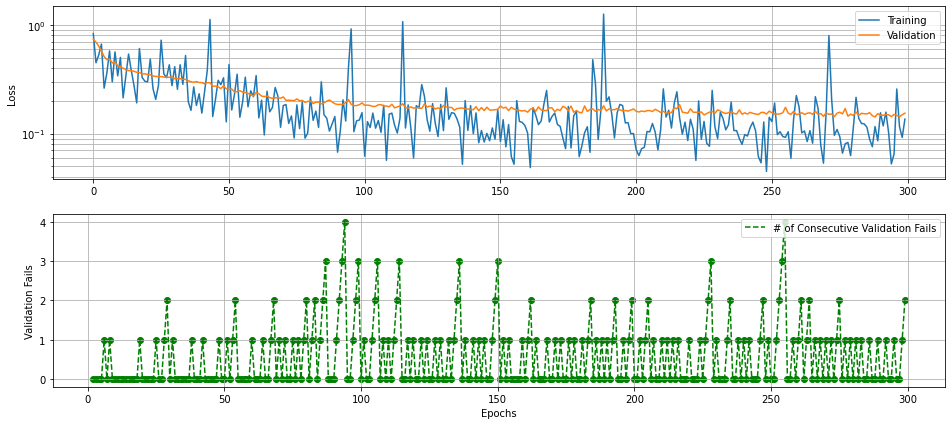

In [27]:
LOG_SCALE = True

# plot loss over time
plt.rcParams['figure.figsize'] = [16, 7]
fig = plt.figure()
axes = fig.subplots(2, 1)
axes[0].grid(which="both")
axes[0].set_ylabel('Loss')
axes[0].plot(train_history[:, 0], train_history[:, 1], label='Training')
axes[0].plot(val_history[:, 0], val_history[:, 1], label='Validation')
axes[0].legend(loc='upper right')
if LOG_SCALE:
    axes[0].set_yscale('log')

axes[1].grid(which="both")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation Fails')
axes[1].plot(val_fail_history[:, 0], val_fail_history[:, 1], label='# of Consecutive Validation Fails', linestyle='--', c='green')
axes[1].scatter(val_fail_history[:, 0], val_fail_history[:, 1], c='green')
axes[1].legend(loc='upper right')

plt.show()